# Head Direction Analyses

Analysis of head direction.

Goal: circular plots of firing rate by head direction.

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO
from pingouin import convert_angles, circ_rayleigh

from spiketools.utils import restrict_range
from spiketools.plts.utils import make_axes

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from analysis import get_spike_heading

## Functions

In [5]:
def bin_circular(degrees):
    """Bin circular data.
    
    Parameters
    ----------
    degrees : 1d array
        xx
    
    Returns
    -------
    bin_edges :
        xx
    counts :
        xx
    """
    
    bin_edges = np.arange(0, 370, 10)
    counts, _ = np.histogram(degrees, bins=bin_edges)
    
    return bin_edges, counts


def plot_polar_hist(degrees, ax=None):
    """Plot a polar histogram.
    
    Parameters
    ----------
    degrees : 1d array
        xx
    """
    
    if not ax:
        ax = plt.subplot(111, polar=True)
    
    bin_edges, counts = bin_circular(degrees)
    bars = ax.bar(bin_edges[:-1], counts)

## Settings

In [6]:
# Set which task to analyze
task = 'THF'

In [7]:
# Define the base data folder
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/' + task)

In [37]:
# Define subject information
subj = 'wv001'
session = 2

In [38]:
# Set which example unit to extract
uind = 20

## Load Data

In [39]:
# Define expected NWB file name & full path
file_name = '_'.join([subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [40]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

In [41]:
# Extract head position data
head_pos = nwbfile.acquisition['position']['head_direction']
times = head_pos.timestamps[:]
degrees = head_pos.data[:]

In [42]:
# HACK - FIX
degrees = degrees + -np.min(degrees[degrees < 0])

In [43]:
# Check how many units are available
n_units = len(nwbfile.units)
print('Number of units: {}'.format(n_units))

Number of units: 81


In [44]:
# Extract spikes for a unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)
spikes = spikes / 1000

In [45]:
# Drop spikes until task time
st = nwbfile.trials['start_time'][0]
en = nwbfile.trials['stop_time'][-1]
spikes = restrict_range(spikes, st, en)

### Head Direction

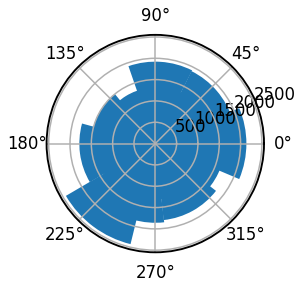

In [46]:
# Plot all head directions
plot_polar_hist(degrees)

In [47]:
# Check for non-uniformity
z_val, p_val = circ_rayleigh(convert_angles(degrees))
z_val, p_val

(559.6556545655576, 1.2417132870322061e-244)

### Head-Direction Related Firing

In [48]:
# Get head direction for each spike
spike_hds = get_spike_heading(spikes, times, degrees)

In [ ]:
# Check number of cells with heading direction
print('{:1.2f}% of cells ({} / {})'.format(len(spike_hds) / len(spikes) * 100, len(spike_hds), len(spikes)))

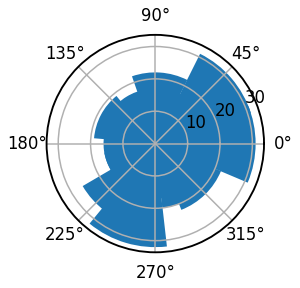

In [50]:
# Plot head direction of spike firing
plot_polar_hist(spike_hds)

In [51]:
# Check for non-uniformity
z_val, p_val = circ_rayleigh(convert_angles(spike_hds))
z_val, p_val

(3.034877137302363, 0.048001154678166985)

## All Cells

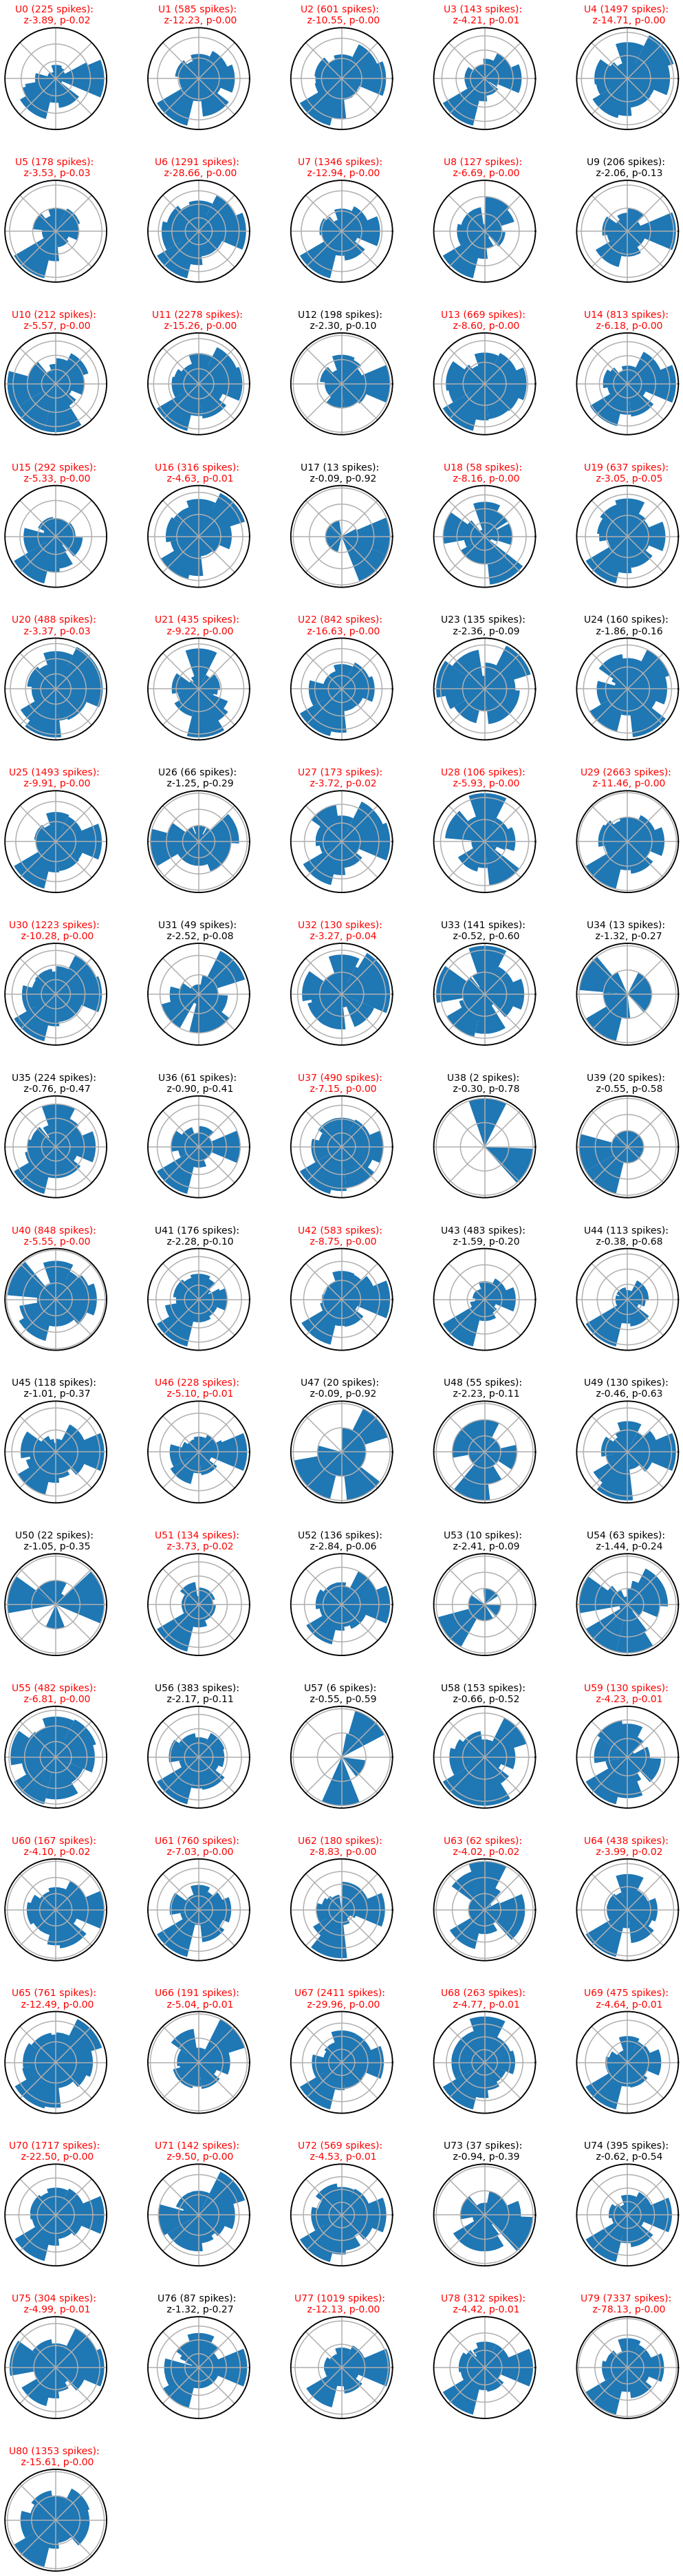

In [52]:
# Examine head-direction related firing across all cells
for ii, ax in zip(range(n_units), make_axes(n_units, subplot_kw={'projection': 'polar'}, hspace=0.5)):
    
    spikes = nwbfile.units.get_unit_spike_times(ii) / 1000
    
    spike_hds = get_spike_heading(spikes, times, degrees)
    
    if len(spike_hds) == 0:
        continue
    
    z_val, p_val = circ_rayleigh(convert_angles(spike_hds))
    
    plot_polar_hist(spike_hds, ax=ax)
    title = 'U{} ({:d} spikes): \n z-{:1.2f}, p-{:1.2f}'.format(ii, len(spike_hds), z_val, p_val)
    color = 'red' if p_val < 0.05 else 'black'
    ax.set_title(title, color=color, fontdict={'fontsize' : 14})
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])